In [36]:
import pandas as pd
import numpy as np

In [37]:
raw_data = pd.read_csv("Bitcoin History.csv")
raw_data.head()

,Date,Price,Open,High,Low,Vol.,Change %
0,"Feb 09, 2024","47,545.4","45,293.3","47,710.2","45,254.2",86.85K,4.97%
1,"Feb 08, 2024","45,293.3","44,346.2","45,579.2","44,336.4",66.38K,2.15%
2,"Feb 07, 2024","44,339.8","43,088.4","44,367.9","42,783.5",48.57K,2.91%
3,"Feb 06, 2024","43,087.7","42,697.6","43,375.5","42,566.8",33.32K,0.91%
4,"Feb 05, 2024","42,697.2","42,581.4","43,532.2","42,272.5",39.26K,0.27%


In [38]:
raw_data["Date"][180].replace(",","").split(" ")

['Aug', '13', '2023']

In [39]:
pd.to_datetime("2023-8-13")

Timestamp('2023-08-13 00:00:00')

In [40]:
def parse_date(date:str) ->pd.Timestamp:
    months = {"Jan":1,
              "Feb":2,
              "Mar":3,
              "Apr":4,
              "May":5,
              "Jun":6,
              "Jul":7,
              "Aug":8,
              "Sep":9,
              "Oct":10,
              "Nov":11,
              "Dec":12}
    
    list_date = date.replace(",","").split(" ")

    year = list_date[2]
    day = list_date[1]
    month = months[list_date[0]]

    datetime_date = pd.to_datetime(f"{year}-{month}-{day}")
    
    return datetime_date


In [41]:
raw_data["Date"] = raw_data["Date"].map(parse_date)
raw_data.head()

,Date,Price,Open,High,Low,Vol.,Change %
0,2024-02-09,"47,545.4","45,293.3","47,710.2","45,254.2",86.85K,4.97%
1,2024-02-08,"45,293.3","44,346.2","45,579.2","44,336.4",66.38K,2.15%
2,2024-02-07,"44,339.8","43,088.4","44,367.9","42,783.5",48.57K,2.91%
3,2024-02-06,"43,087.7","42,697.6","43,375.5","42,566.8",33.32K,0.91%
4,2024-02-05,"42,697.2","42,581.4","43,532.2","42,272.5",39.26K,0.27%


In [42]:
def parse_price(price:str) -> float:
    return float(price.replace(",",""))

raw_data["Price"] = raw_data["Price"].map(parse_price)
raw_data["Open"] = raw_data["Open"].map(parse_price)
raw_data["High"] = raw_data["High"].map(parse_price)
raw_data["Low"] = raw_data["Low"].map(parse_price)

raw_data.head()

,Date,Price,Open,High,Low,Vol.,Change %
0,2024-02-09,47545.4,45293.3,47710.2,45254.2,86.85K,4.97%
1,2024-02-08,45293.3,44346.2,45579.2,44336.4,66.38K,2.15%
2,2024-02-07,44339.8,43088.4,44367.9,42783.5,48.57K,2.91%
3,2024-02-06,43087.7,42697.6,43375.5,42566.8,33.32K,0.91%
4,2024-02-05,42697.2,42581.4,43532.2,42272.5,39.26K,0.27%


In [43]:
def parse_volume(volume:str) ->float:
    if volume == "-":
        return 0
    return float(volume[:4]) * 1000

raw_data["Vol."] = raw_data["Vol."].map(parse_volume)

In [44]:
def parse_percent(value:str) -> float:
    return float(value[:3])

raw_data["Change %"] = raw_data["Change %"].map(parse_percent)

In [45]:
raw_data.head()

,Date,Price,Open,High,Low,Vol.,Change %
0,2024-02-09,47545.4,45293.3,47710.2,45254.2,86800.0,4.9
1,2024-02-08,45293.3,44346.2,45579.2,44336.4,66300.0,2.1
2,2024-02-07,44339.8,43088.4,44367.9,42783.5,48500.0,2.9
3,2024-02-06,43087.7,42697.6,43375.5,42566.8,33300.0,0.9
4,2024-02-05,42697.2,42581.4,43532.2,42272.5,39200.0,0.2


In [46]:
def split_dates(data:pd.DataFrame) -> pd.DataFrame:
    copy = data.copy()

    copy["day"] = copy["Date"].dt.day
    copy["month"] = copy["Date"].dt.month
    copy["year"] = copy["Date"].dt.year
    copy["day_of_week"] = copy["Date"].dt.day_of_week

    copy = copy.drop("Date", axis=1)

    return copy

df = split_dates(raw_data)
df.head()

,Price,Open,High,Low,Vol.,Change %,day,month,year,day_of_week
0,47545.4,45293.3,47710.2,45254.2,86800.0,4.9,9,2,2024,4
1,45293.3,44346.2,45579.2,44336.4,66300.0,2.1,8,2,2024,3
2,44339.8,43088.4,44367.9,42783.5,48500.0,2.9,7,2,2024,2
3,43087.7,42697.6,43375.5,42566.8,33300.0,0.9,6,2,2024,1
4,42697.2,42581.4,43532.2,42272.5,39200.0,0.2,5,2,2024,0


In [47]:
from category_encoders import TargetEncoder

df = pd.get_dummies(df,columns=["day_of_week"], drop_first=True)

# X = TargetEncoder(cols=["day_of_week"]).fit_transform(df.drop("Price",axis=1),df["Price"])
# X.head()

In [13]:
# df = pd.concat([X,df["Price"]],axis=1)

<AxesSubplot: xlabel='month', ylabel='Price'>

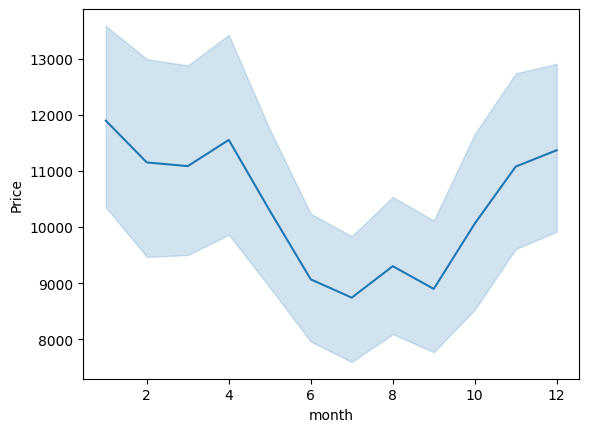

In [14]:
import seaborn as sns

sns.lineplot(df,x="month",y="Price")

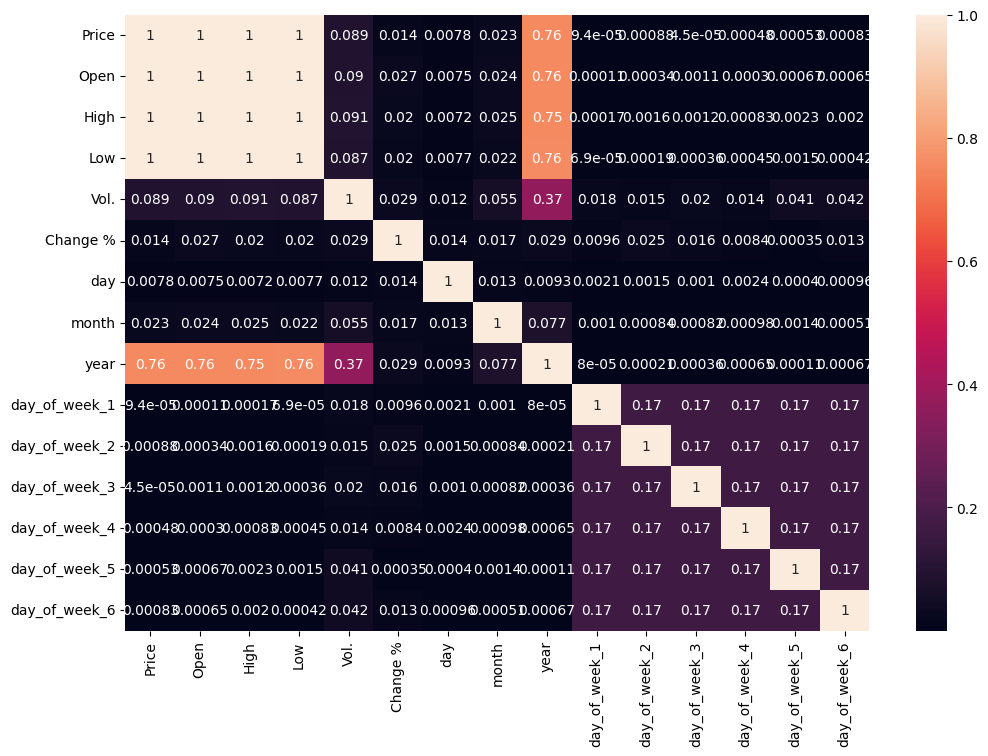

In [48]:
import matplotlib.pyplot as plt

plt.figure().set_size_inches(12,8)
sns.heatmap(abs(df.corr()), annot=True)
plt.show()

In [49]:
train = df[df["year"]<=2023]
test = df[df["year"]>2023]

In [50]:

def train_test_split(train:pd.DataFrame,test:pd.DataFrame, log:bool) -> tuple:
    X_train = train.drop("Price", axis=1)
    X_test = test.drop("Price", axis=1)

    if log == False:
        y_train = train["Price"]
        y_test = test["Price"]
    
    elif log == True:
        y_train = np.log(train["Price"])
        y_test = np.log(test["Price"])

    return X_train,X_test,y_train,y_test

cols_to_drop = ["year","day"]

X_train,X_test,y_train,y_test = train_test_split(train.drop(cols_to_drop, axis=1),
                                                 test.drop(cols_to_drop, axis=1),
                                                 log=True)

In [51]:
from sklearn.linear_model import Lasso
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, Normalizer

lasso_pipe = Pipeline([("scaler",StandardScaler()),( "lasso",Lasso())])

lasso_pipe.fit(X_train,y_train)

Pipeline(steps=[('scaler', StandardScaler()), ('lasso', Lasso())])

In [52]:
lasso_pipe["lasso"].coef_

array([ 0.        ,  0.        ,  1.26792288,  0.09040618, -0.        ,
       -0.        , -0.        ,  0.        , -0.        ,  0.        ,
        0.        , -0.        ])

In [53]:
from sklearn.metrics import mean_absolute_error as mae, mean_squared_error as mse

def print_deviations(estimator,X_test,y_test,log_target:bool):
    if log_target == False:
        print(f"MAE: {mae(y_test,estimator.predict(X_test))}")
        print(f"MSE: {mse(y_test,estimator.predict(X_test))}")
        print(f"RMSE: {mse(y_test,estimator.predict(X_test))**0.5}")
    elif log_target == True:
        print(f"RMLSE: {mse(y_test,estimator.predict(X_test))**0.5}")

print_deviations(lasso_pipe,X_test,y_test,log_target=True)

def plot_results(estimator,X_train,X_test,y_train,y_test):
    """Графическое отображение предсказаний модели"""
    
    train_preds = estimator.predict(X_train)
    test_preds = estimator.predict(X_test)

    df_train = pd.DataFrame({"X_train_preds":train_preds,
                             "y_train":y_train})
    
    df_test = pd.DataFrame({"X_test_preds":test_preds,
                            "y_test":y_test})
    
    plt.figure().set_size_inches(12,8)

    ax1 = plt.subplot(1,2,1)
    plt.title("Train")
    sns.lineplot(df_train)
    plt.tight_layout()
    # plt.show()

    ax2 = plt.subplot(1,2,2)
    plt.title("Test")
    sns.lineplot(df_test)
    plt.tight_layout()
    # plt.show()

RMLSE: 1.12485259582322


RMLSE: 0.008535486745303399


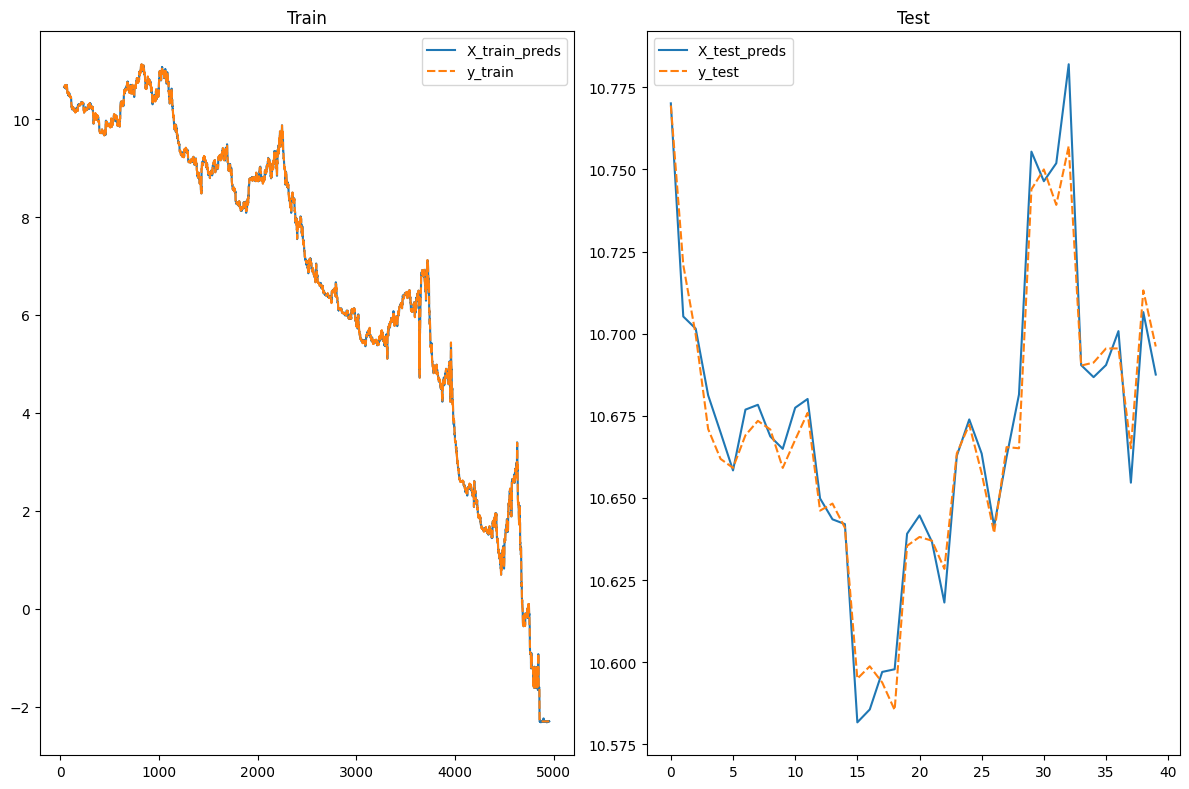

In [54]:
from xgboost import XGBRegressor

xgb_pipe = Pipeline([("scaler",StandardScaler()),("xgb",XGBRegressor())])

xgb_pipe.fit(X_train,y_train)

print_deviations(xgb_pipe,X_test,y_test,log_target=True)

plot_results(xgb_pipe,X_train,X_test,y_train,y_test)

Learning rate set to 0.052655
0:	learn: 3.2263864	total: 1.86ms	remaining: 1.86s
1:	learn: 3.0657546	total: 3.5ms	remaining: 1.75s
2:	learn: 2.9133406	total: 5.24ms	remaining: 1.74s
3:	learn: 2.7680250	total: 7.23ms	remaining: 1.8s
4:	learn: 2.6335050	total: 8.81ms	remaining: 1.75s
5:	learn: 2.4994897	total: 10.7ms	remaining: 1.77s
6:	learn: 2.3768954	total: 12.3ms	remaining: 1.74s
7:	learn: 2.2583991	total: 13.9ms	remaining: 1.73s
8:	learn: 2.1456552	total: 15.6ms	remaining: 1.71s
9:	learn: 2.0366142	total: 17.7ms	remaining: 1.75s
10:	learn: 1.9376857	total: 19.7ms	remaining: 1.77s
11:	learn: 1.8431640	total: 21.7ms	remaining: 1.78s
12:	learn: 1.7557617	total: 23.2ms	remaining: 1.76s
13:	learn: 1.6692172	total: 24.7ms	remaining: 1.74s
14:	learn: 1.5870777	total: 26.1ms	remaining: 1.71s
15:	learn: 1.5109550	total: 27.7ms	remaining: 1.71s
16:	learn: 1.4365415	total: 29.3ms	remaining: 1.7s
17:	learn: 1.3660263	total: 31.1ms	remaining: 1.7s
18:	learn: 1.2975282	total: 32.8ms	remaining: 1.

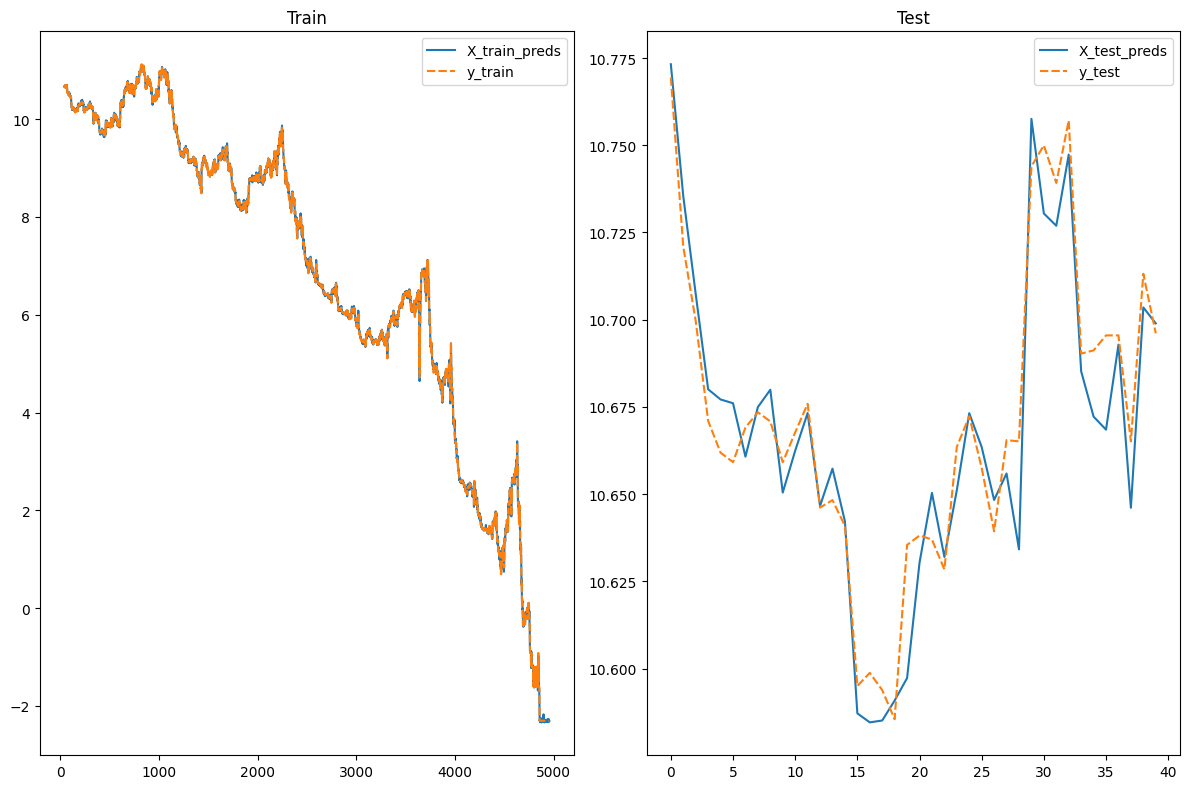

In [55]:
from catboost import CatBoostRegressor

cat_pipe = Pipeline([("scaler",StandardScaler()),("catboost",CatBoostRegressor())])

cat_pipe.fit(X_train,y_train)

print_deviations(cat_pipe,X_test,y_test,log_target=True)

plot_results(cat_pipe,X_train,X_test,y_train,y_test)

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000276 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1187
[LightGBM] [Info] Number of data points in the train set: 4915, number of used features: 12
[LightGBM] [Info] Start training from score 6.773215
RMLSE: 0.010009571346722082


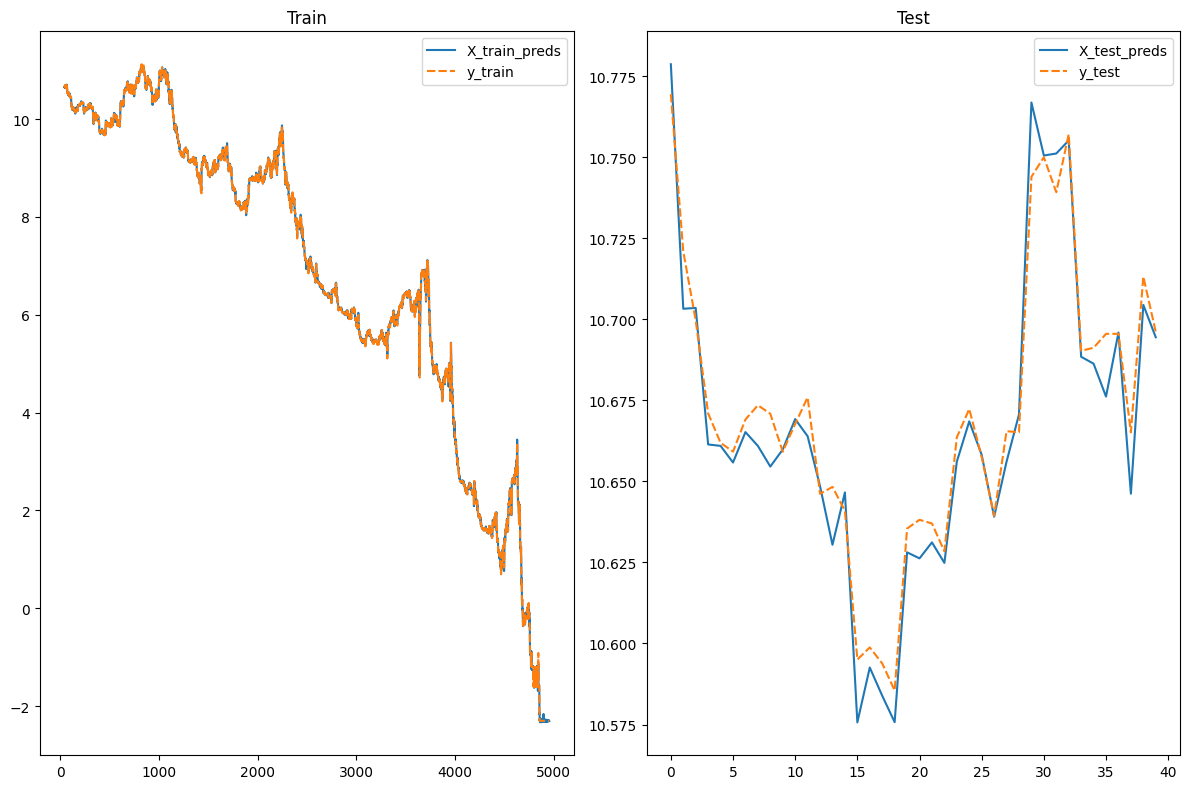

In [56]:
from lightgbm import LGBMRegressor

lgbm_pipe = Pipeline([("scaler",StandardScaler()),("lgbm",LGBMRegressor())])

lgbm_pipe.fit(X_train,y_train)

print_deviations(lgbm_pipe,X_test,y_test,log_target=True)

plot_results(lgbm_pipe,X_train,X_test,y_train,y_test)